In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
plt.style.use('ggplot')

SELL_PRICES_PATH = pathlib.Path("../data/raw/sell_prices.csv")

## Prices dataframe

In [2]:
df_prices = pd.read_csv(SELL_PRICES_PATH)

# Assign categories
df_prices = df_prices.assign(
    category = df_prices['item_id'].apply(lambda x : x.split('_')[0]),
    subcategory = df_prices['item_id'].apply(lambda x : x.split('_')[1]),
)

In [6]:
df_prices.head()

,store_id,item_id,wm_yr_wk,sell_price,category,subcategory
0,CA_1,HOBBIES_1_001,11325,9.58,HOBBIES,1
1,CA_1,HOBBIES_1_001,11326,9.58,HOBBIES,1
2,CA_1,HOBBIES_1_001,11327,8.26,HOBBIES,1
3,CA_1,HOBBIES_1_001,11328,8.26,HOBBIES,1
4,CA_1,HOBBIES_1_001,11329,8.26,HOBBIES,1


In [3]:
print("\nNo N/A records")
display(df_prices.isna().any())

print("\nHow many stores?")
print(df_prices['store_id'].nunique())

print("\nHow many unique items?")
print(df_prices['item_id'].nunique())

print("\nWhat are the items categories?")
display(df_prices['category'].unique())

print("\nHow many items in each category?")
display(
    df_prices
    .groupby(['category'])
    .agg(
        subcategory_count = ('subcategory', 'nunique')
    ))

print("\nHow many unique items?")
display(
    df_prices.groupby(['category', 'subcategory']).agg(unique_items = ('item_id', 'nunique'))
)


No N/A records


store_id       False
item_id        False
wm_yr_wk       False
sell_price     False
category       False
subcategory    False
dtype: bool


How many stores?
10

How many unique items?
3049

What are the items categories?


array(['HOBBIES', 'HOUSEHOLD', 'FOODS'], dtype=object)


How many items in each category?


,subcategory_count
category,
FOODS,3
HOBBIES,2
HOUSEHOLD,2



How many unique items?


unique_items
category  subcategory              
FOODS     1                     216
          2                     398
          3                     823
HOBBIES   1                     416
          2                     149
HOUSEHOLD 1                     532
          2                     515

## Prices for different categories

In [37]:
categories = list(df_prices.category.unique())

HOBBIES : 3.97
HOUSEHOLD : 4.94
FOODS : 2.68


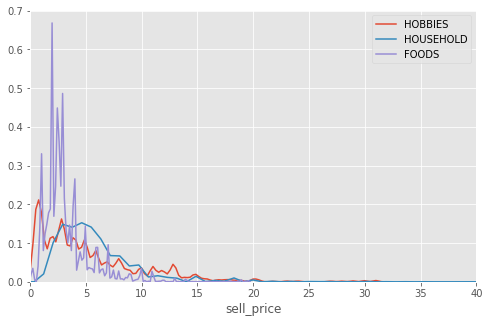

In [35]:
fig, ax = plt.subplots(figsize=(8,5))

for category in categories:
    prices = df_prices.query("category == @category")['sell_price']
    sns.distplot(prices, ax=ax, label=category, hist=False)
    print(f"{category} : {prices.median()}")
ax.set_xlim(0,40)
ax.legend()

We see that the median are similar.

However, food and hobbies are cheaper than household items

C:\Users\XT\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


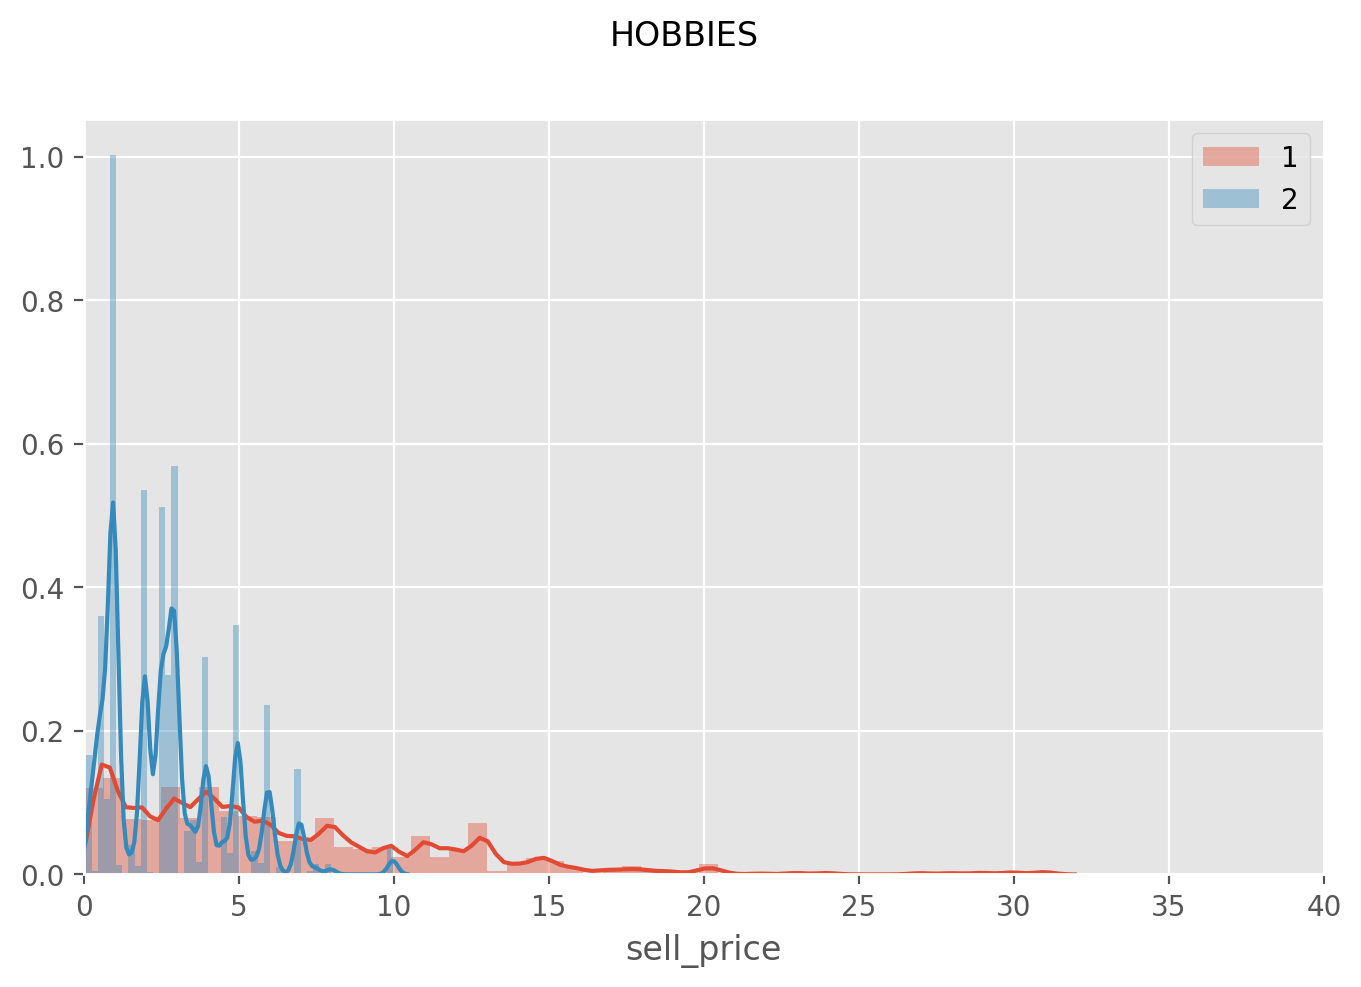

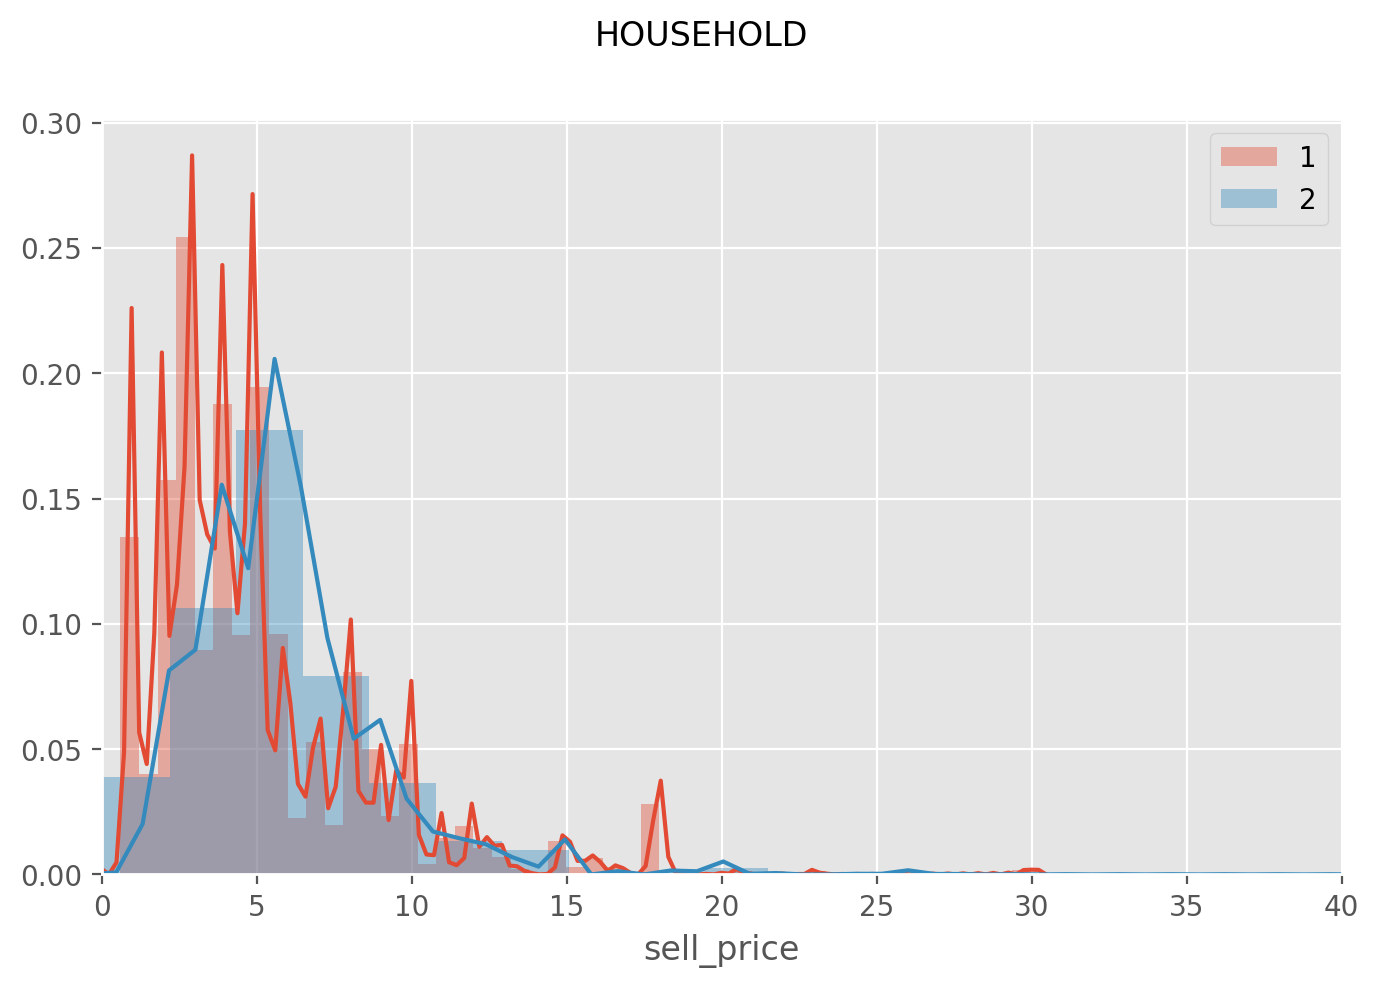

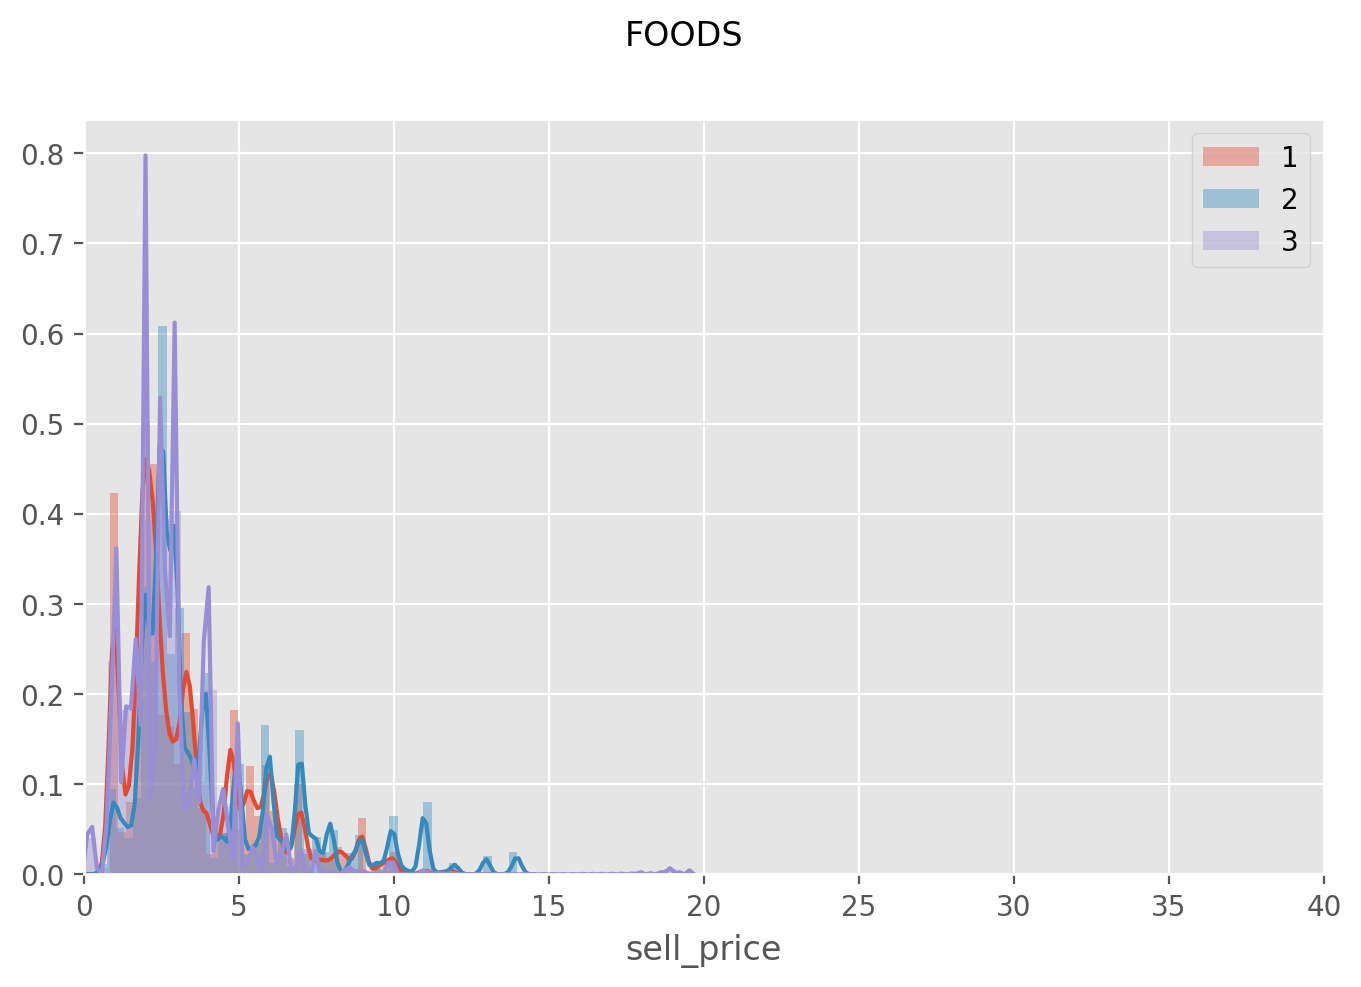

In [41]:
for category in categories: 
    fig, ax = plt.subplots(figsize=(8,5), dpi=200)
    fig.suptitle(category)
    df_cat = df_prices.query("category == @category")
    for subcat in df_cat['subcategory'].unique():
        prices = df_cat.query("subcategory == @subcat")['sell_price']
        sns.distplot(prices, ax=ax, label=subcat)
    ax.set_xlim(0,40)
    ax.legend()
    fig.show()

## Food items - price endings

In [109]:
import matplotlib.ticker as ticker

In [119]:
def plot_price_endings(category):
    price_cents = (
        df_prices
        .query("category == @category")['sell_price']
        .apply(lambda x : str(x).split('.')[1])
        .value_counts()
        .reset_index()
        .assign(
            cents = lambda x : list(x['index'].values),
            count = lambda x : x['sell_price']
        )
        .drop(['index','sell_price'], axis=1)
    )
    
    # Plotting
    fig, ax = plt.subplots(figsize=(10,5), dpi=200)
    fig.suptitle(f'Price endings - {category}')
    sns.barplot(
        data=price_cents,
        x='cents',
        y='count'
    )
    fig.show()
    
    display(price_cents.head(10))

C:\Users\XT\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


,cents,count
0,98,837020
1,48,259713
2,5,238237
3,0,229250
4,88,199965
5,68,163635
6,28,121471
7,97,109440
8,78,107742
9,18,81984


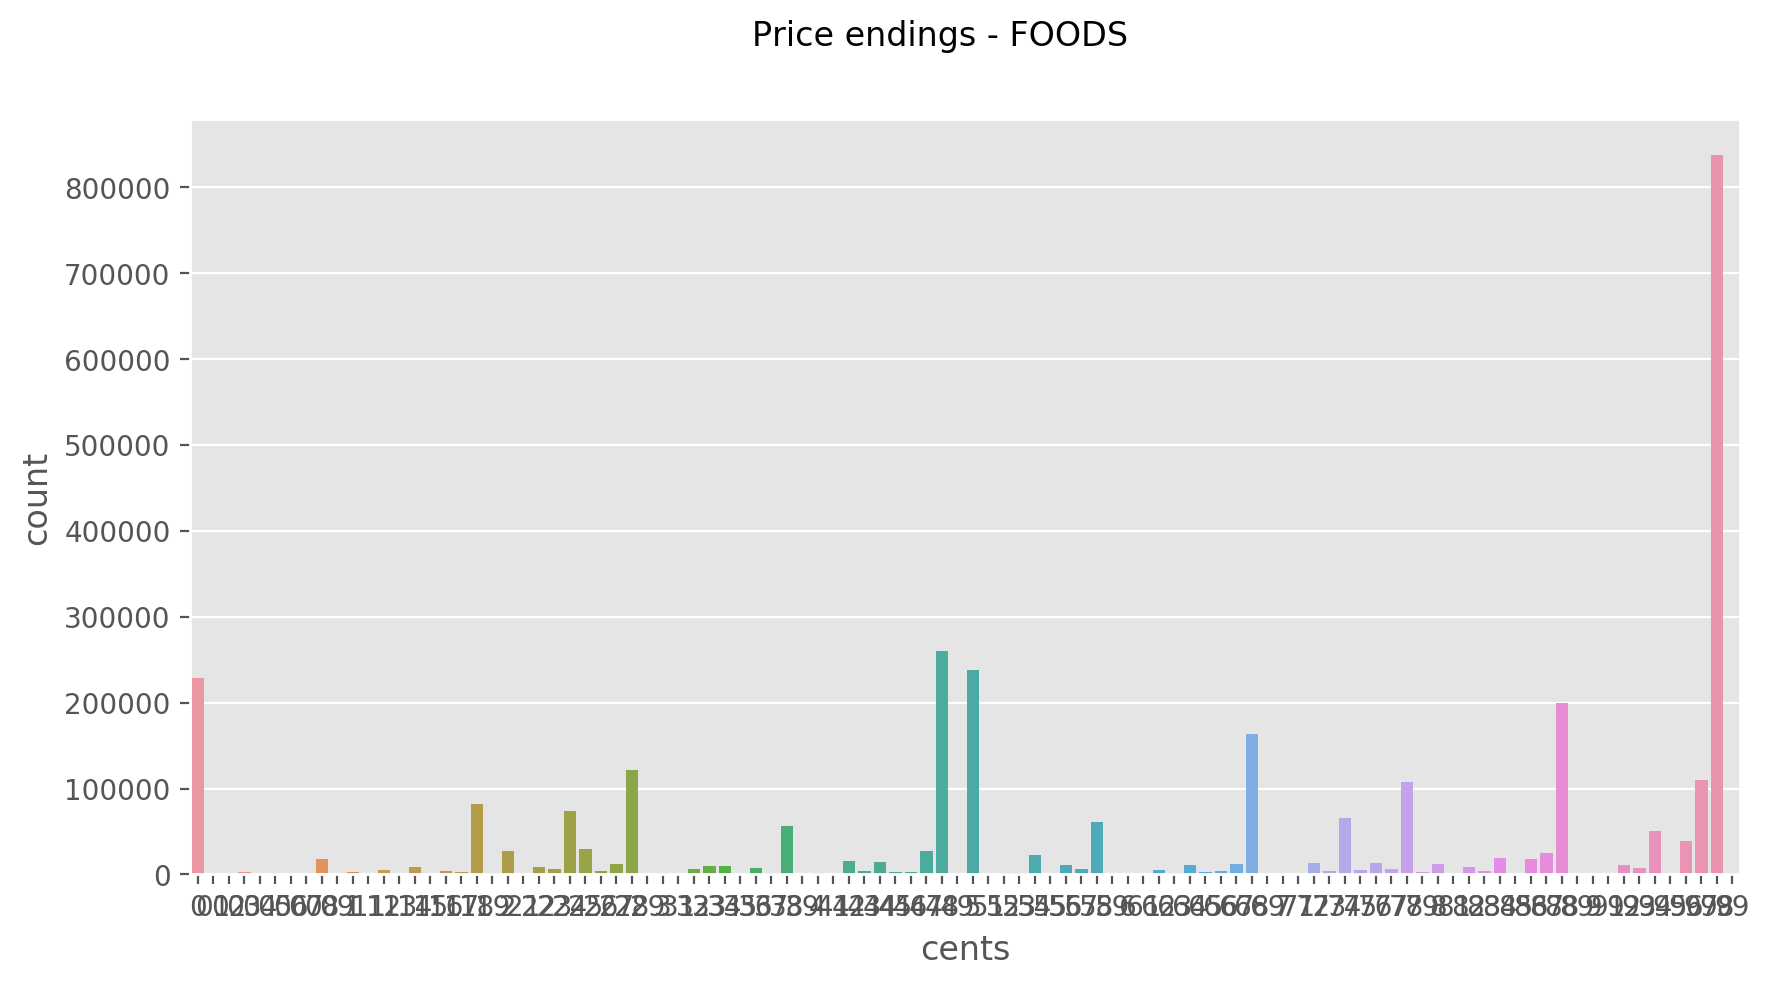

In [120]:
plot_price_endings('FOODS')

Walmart likes to price their food item at `$X.98`, `$X.00$`, `$X.48`, `$X.50`

C:\Users\XT\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


,cents,count
0,97,769225
1,47,203043
2,94,190538
3,98,186799
4,48,109536
5,88,97363
6,87,70190
7,96,55870
8,67,55804
9,27,54640


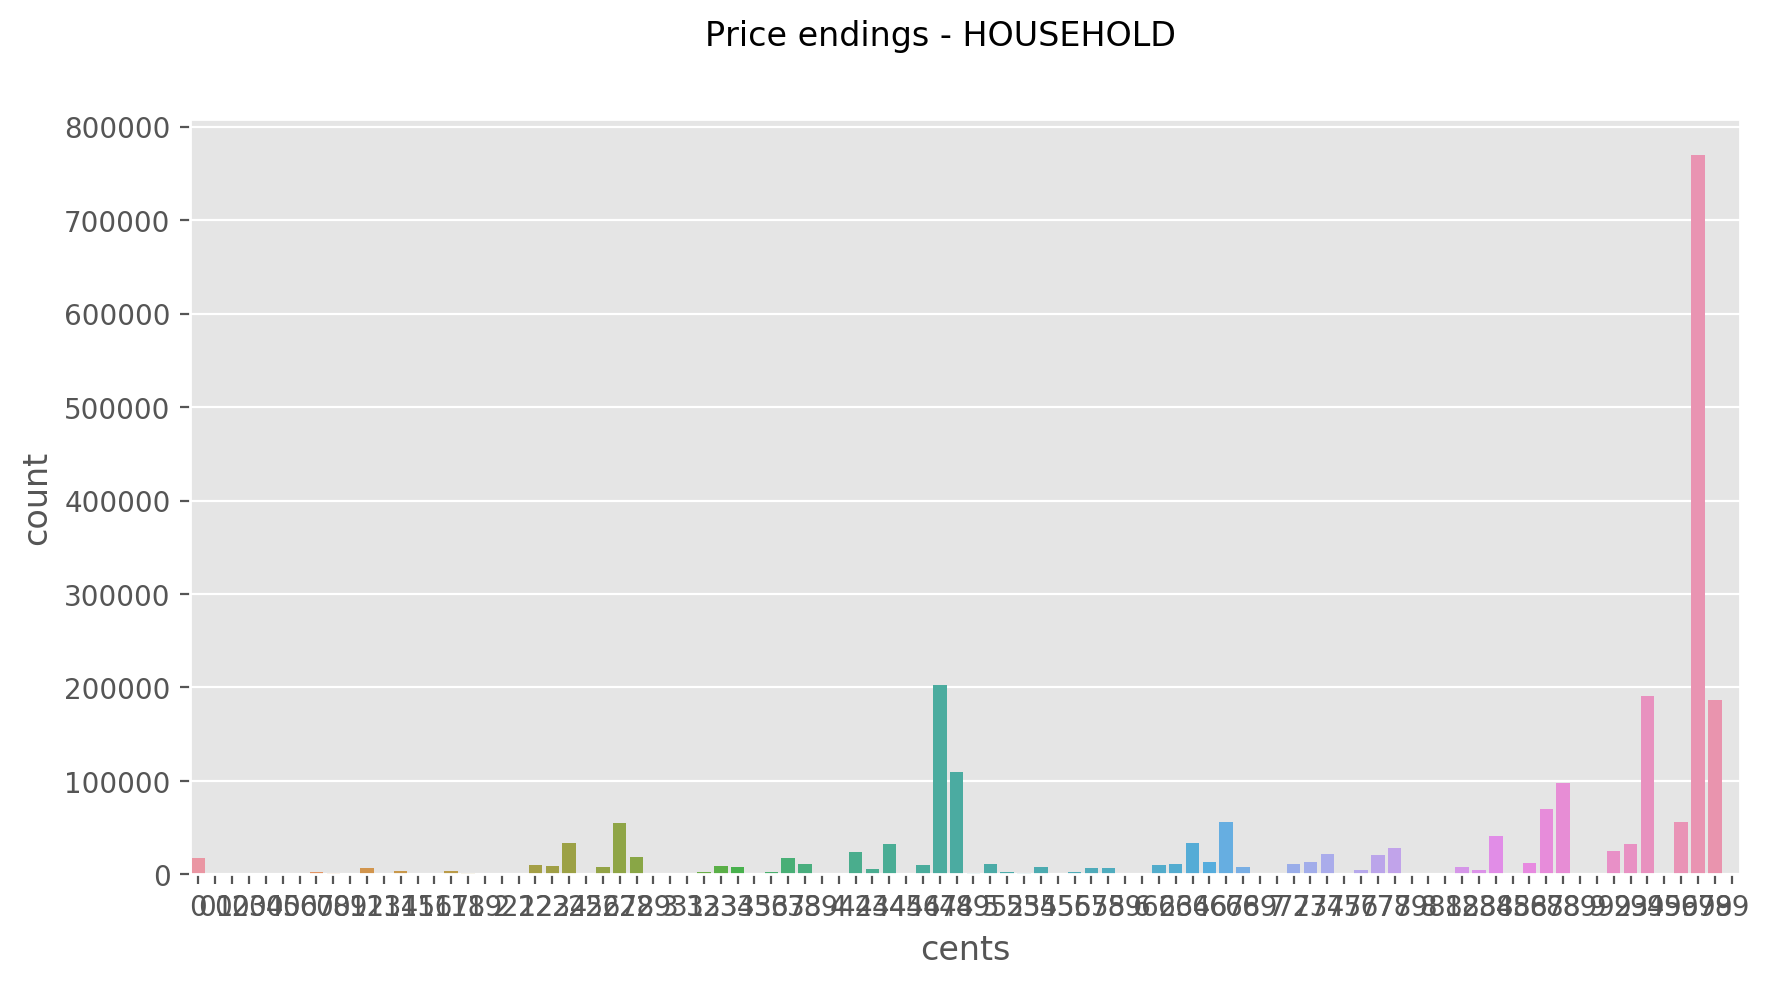

In [121]:
plot_price_endings('HOUSEHOLD')

C:\Users\XT\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


,cents,count
0,97,290031
1,98,136313
2,88,135786
3,47,62421
4,77,54617
5,48,44179
6,68,39798
7,5,37925
8,24,23828
9,57,23344


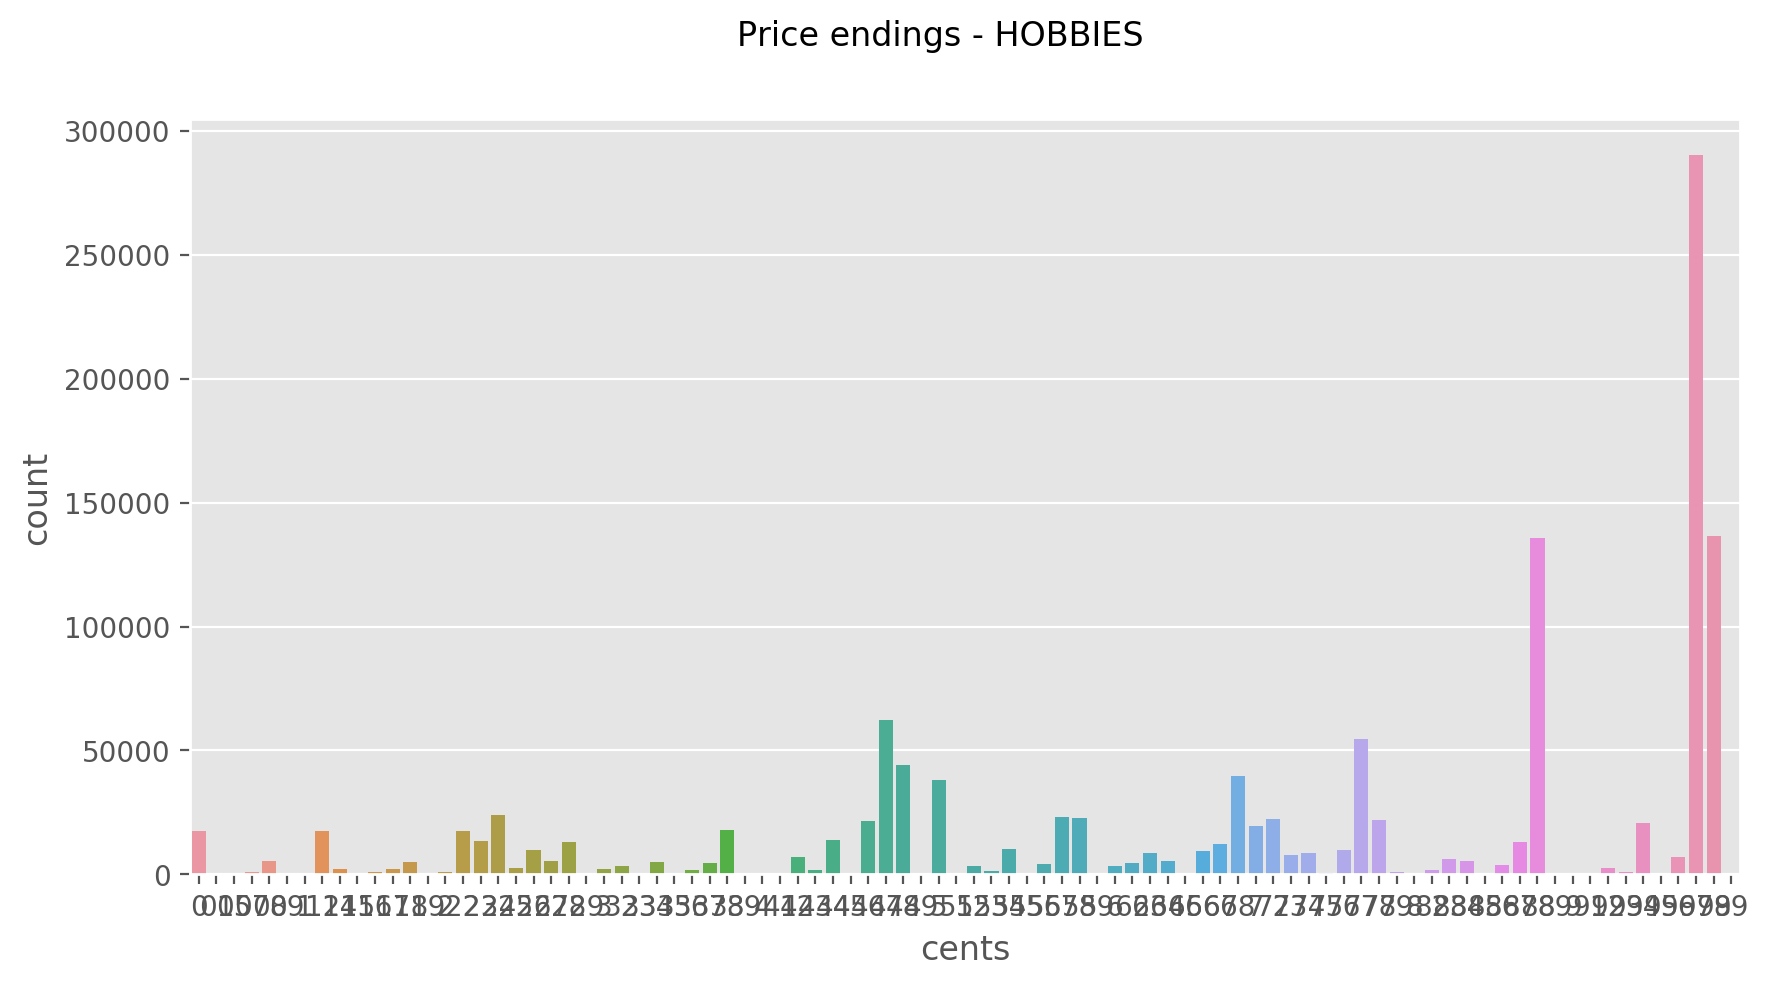

In [122]:
plot_price_endings('HOBBIES')

Very interesting that Wal-Mart never prices things at `$X.99`, probably because people became accustomed to the trick?

Also, household items are almost exclusively priced at `$X.97/98` or `$X.47/48` meanwhile other items have a more varied pricing scheme

## Time and price

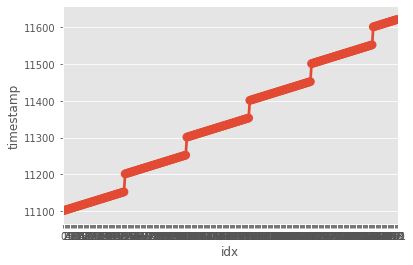

In [133]:
sns.pointplot(
    data=pd.DataFrame({
        'idx' : range(len(df_prices['wm_yr_wk'].unique())),
        'timestamp' : df_prices['wm_yr_wk'].sort_values().unique()
    }),
    x='idx',
    y='timestamp'
)

In [134]:
df_prices['wm_yr_wk']

0          11325
1          11326
2          11327
3          11328
4          11329
           ...  
6841116    11617
6841117    11618
6841118    11619
6841119    11620
6841120    11621
Name: wm_yr_wk, Length: 6841121, dtype: int64